# Imports

In [1]:
!pip install evaluate
!pip install rouge_score

In [17]:
import pandas as pd
import os
import cv2
import numpy as np
import pickle
import json
import ast
import evaluate
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
print('Imports Done!')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Imports Done!


In [3]:
bleu_metric = evaluate.load("bleu")
def compute_metrics(predicted, label):
    """
    Compute BLEU, ROUGE, and METEOR scores for a single predicted sentence
    against a single reference sentence.

    Args:
    predicted (str): The predicted sentence.
    label (str): The ground-truth reference sentence.

    Returns:
    dict: A dictionary containing BLEU, ROUGE-1, ROUGE-2, ROUGE-L, and METEOR scores.
    """
    # Initialize BLEU metric from evaluate

    # Compute BLEU score
    bleu_1 = bleu_metric.compute(predictions=[predicted], references=[[label]], max_order=1)['bleu']
    bleu_2 = bleu_metric.compute(predictions=[predicted], references=[[label]], max_order=2)['bleu']

    # Initialize ROUGE scorer
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = rouge_scorer_instance.score(label, predicted)

    # Extract ROUGE scores
    rouge_scores = {
        "ROUGE-1": scores['rouge1'].fmeasure,
        "ROUGE-2": scores['rouge2'].fmeasure,
        "ROUGE-L": scores['rougeL'].fmeasure
    }

    # Compute METEOR score (tokenizing both label and prediction)
    meteor = meteor_score([label.split()], predicted.split())

    # Return the results
    return {
        "BLEU-1": bleu_1,
        "BLEU-2": bleu_2,
        "ROUGE-1": rouge_scores["ROUGE-1"],
        "ROUGE-2": rouge_scores["ROUGE-2"],
        "ROUGE-L": rouge_scores["ROUGE-L"],
        "METEOR": meteor
    }

def evaluate_model(predictions, labels):
    """
    Evaluate a list of predictions against their corresponding single reference sentences.
    Calls `compute_metrics` for each prediction-label pair and aggregates results.

    Args:
    predictions (list of str): The predicted sentences.
    labels (list of str): The ground-truth reference sentences.

    Returns:
    dict: A dictionary with average BLEU, ROUGE-1, ROUGE-2, ROUGE-L, and METEOR scores,
          as well as a detailed breakdown of scores for each prediction.
    """
    assert len(predictions) == len(labels), "The number of predictions and labels must match."

    # Initialize accumulators for metrics
    metrics_summary = {
        "BLEU-1": [],
        "BLEU-2": [],
        "ROUGE-1": [],
        "ROUGE-2": [],
        "ROUGE-L": [],
        "METEOR": []
    }
    detailed_metrics = []

    # Compute metrics for each prediction
    for pred, label in zip(predictions, labels):
        metrics = compute_metrics(pred, label)
        detailed_metrics.append(metrics)

        for key in metrics:
            metrics_summary[key].append(metrics[key])

    # Compute average metrics
    avg_metrics = {key: sum(values) / len(values) for key, values in metrics_summary.items()}

    return {
        "Average Metrics": avg_metrics,
        "Detailed Metrics": detailed_metrics
    }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Now we will import the different json files and make a pandas dataframe with all the information.

In [4]:
# Load the JSON file
with open('CanYouDescribeTheImage.json', 'r') as file:
    json_data = json.load(file)

# Convert JSON data to a pandas DataFrame
df = pd.DataFrame(json_data, columns=["Baseline", "Image"])

# Load the second JSON file
with open('CanYouGiveATitleToThisDish.json', 'r') as file:
    new_json_data = json.load(file)

# Convert new JSON data to a pandas DataFrame
new_df = pd.DataFrame(new_json_data, columns=["TitleToDish", "Ground Truth", "Image"])

# Merge the two DataFrames on the Image column to ensure data sharing the same Image is on the same row
df = pd.merge(df, new_df, on="Image", how="outer")


# Load the JSON file into a Pandas DataFrame
file_path = 'what_is_the_name_of_this_dish.json'  # Replace with your JSON file path

# Initialize a list to store data from each line
data = []

# Read and parse the file line-by-line
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()  # Remove extra whitespace
        if line.startswith("[") and line.endswith("]"):  # Ensure it's a JSON array
            try:
                # Parse the line as a JSON array
                parsed_line = json.loads(line)
                data.append(parsed_line)  # Add the parsed data to the list
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line}\nError: {e}")
        else:
            print(f"Skipping malformed line: {line}")
print("The length of the data is:", len(data))

# Check if data was successfully collected
if not data:
    print("No valid data found in the file.")
else:
    # Convert the data into a DataFrame
    new_df = pd.DataFrame(data, columns=["NameOfDish", "Ground Truth", "Image"])
    del new_df["Ground Truth"]
    # Merge the two DataFrames on the Image column to ensure data sharing the same Image is on the same row
    df = pd.merge(df, new_df, on="Image", how="outer")


# File path to the JSON file
file_path = 'finetuned_1_epoch.json'

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)  # Parse the JSON file as a dictionary

# Convert the JSON dictionary into a DataFrame
new_df = pd.DataFrame.from_dict(data, orient='index')

# Reset the index and move the row key into a new column named "Image"
new_df = new_df.reset_index().rename(columns={"index": "Image"})

new_df["Image"] = new_df["Image"] + ".jpg"
del new_df['actual_title']
new_df.rename(columns = {'predicted_title': 'Finetuned'}, inplace = True)

# Merge the two DataFrames on the Image column to ensure data sharing the same Image is on the same row
df = pd.merge(df, new_df, on="Image", how="outer")

Skipping malformed line: [
Skipping malformed line: ]
The length of the data is: 1252


In [5]:
len(df)

1252

In [6]:
df.head(1)

,Baseline,Image,TitleToDish,Ground Truth,NameOfDish,Finetuned
0,User:<image>Can you describe the image?\nAssis...,10-minute-chicken-flatbreads-with-hummus-and-y...,User:<image>Can you give a title to this dish?...,Ground truth: 10-Minute Chicken Flatbreads wit...,User:<image>What is the name of this dish?\nAs...,User: What is the title of this dish?<image>As...


#Cleaning the Dataframe

In [7]:
def cleaning_df(column):
  new_column = []
  for item in column:
    j = item.split("Assistant: ")[-1]
    if j[-1] == '\.':
      j = j[:-1]
    new_column.append(j)
  return new_column

In [8]:
df['Baseline'] = cleaning_df(df['Baseline'])
df['TitleToDish'] = cleaning_df(df['TitleToDish'])
df['NameOfDish'] = cleaning_df(df['NameOfDish'])
df['Finetuned'] = cleaning_df(df['Finetuned'])
df['Ground Truth'] = df['Ground Truth'].apply(lambda x: x[14:])

In [9]:
df.head(1)

,Baseline,Image,TitleToDish,Ground Truth,NameOfDish,Finetuned
0,The image depicts a festive dining table set w...,10-minute-chicken-flatbreads-with-hummus-and-y...,Mediterranean Dinner Party 2013 101 102 103 10...,10-Minute Chicken Flatbreads with Hummus and Y...,The name of the dish is not mentioned in the i...,Chicken Parmesan Pizza


In [10]:
Comparison = dict()

# Evaluating the base model

Here we are evaluating the base model. The model used is SmolVLM. SmolVLM is a compact open multimodal model that accepts arbitrary sequences of image and text inputs to produce text outputs. The prompt for the inference of the model is the image with the text: "Can you give a title to this dish?".



In [11]:
results = evaluate_model(df['Baseline'], df['Ground Truth'])

Comparison["Baseline"] = results["Average Metrics"]
# Print average metrics
print("Average Metrics:")
for metric, score in results["Average Metrics"].items():
    print(f"{metric}: {score:.4f}")



Average Metrics:
BLEU-1: 0.0154
BLEU-2: 0.0015
ROUGE-1: 0.0564
ROUGE-2: 0.0061
ROUGE-L: 0.0501
METEOR: 0.0703


# Trying different prompts

In [12]:
results = evaluate_model(df['TitleToDish'], df['Ground Truth'])

Comparison["TitleToDish"] = results["Average Metrics"]
# Print average metrics
print("Average Metrics:")
for metric, score in results["Average Metrics"].items():
    print(f"{metric}: {score:.4f}")

Average Metrics:
BLEU-1: 0.0890
BLEU-2: 0.0216
ROUGE-1: 0.1910
ROUGE-2: 0.0461
ROUGE-L: 0.1809
METEOR: 0.0807


In [13]:
results = evaluate_model(df['NameOfDish'], df['Ground Truth'])

Comparison["NameOfDish"] = results["Average Metrics"]
# Print average metrics
print("Average Metrics:")
for metric, score in results["Average Metrics"].items():
    print(f"{metric}: {score:.4f}")

Average Metrics:
BLEU-1: 0.0763
BLEU-2: 0.0146
ROUGE-1: 0.1806
ROUGE-2: 0.0337
ROUGE-L: 0.1742
METEOR: 0.0536


# Finetuned Model

In [14]:
results = evaluate_model(df['Finetuned'], df['Ground Truth'])

Comparison["Finetuned"] = results["Average Metrics"]
# Print average metrics
print("Average Metrics:")
for metric, score in results["Average Metrics"].items():
    print(f"{metric}: {score:.4f}")

Average Metrics:
BLEU-1: 0.2073
BLEU-2: 0.0770
ROUGE-1: 0.2974
ROUGE-2: 0.0848
ROUGE-L: 0.2737
METEOR: 0.1910


# Comparison

In [16]:
# Convert to DataFrame
table = pd.DataFrame(Comparison).T
print(table)


               BLEU-1    BLEU-2   ROUGE-1   ROUGE-2   ROUGE-L    METEOR
Baseline     0.015415  0.001506  0.056363  0.006111  0.050084  0.070348
TitleToDish  0.089039  0.021648  0.191028  0.046101  0.180944  0.080743
NameOfDish   0.076303  0.014632  0.180630  0.033686  0.174233  0.053580
Finetuned    0.207295  0.076954  0.297425  0.084763  0.273710  0.190989


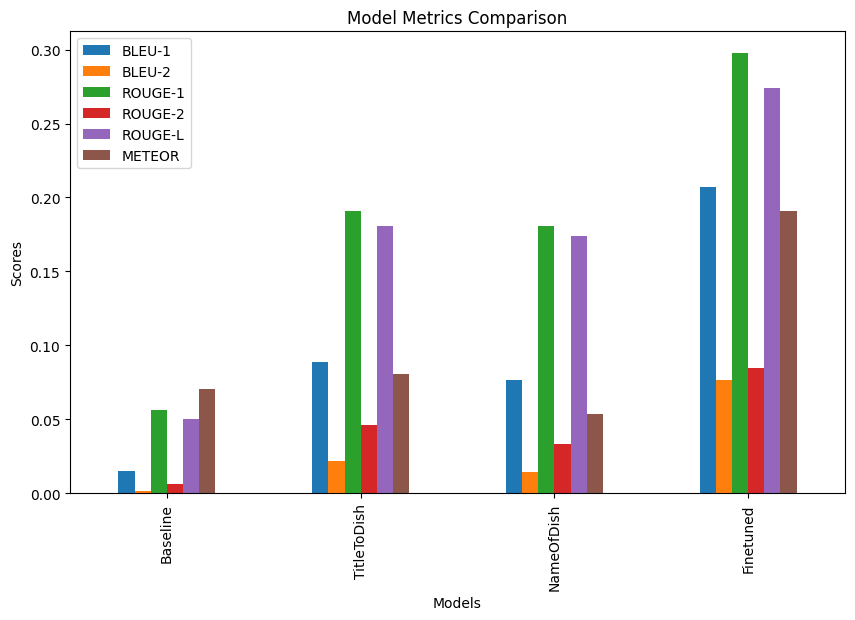

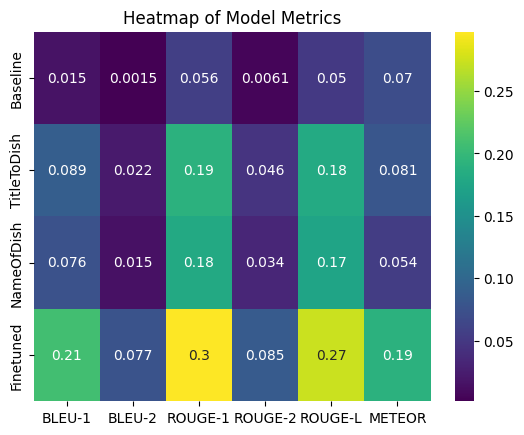

In [19]:
# Bar Plot
table.plot(kind='bar', figsize=(10, 6))
plt.title("Model Metrics Comparison")
plt.ylabel("Scores")
plt.xlabel("Models")
plt.show()

# Heatmap
sns.heatmap(table, annot=True, cmap="viridis")
plt.title("Heatmap of Model Metrics")
plt.show()
